This is the fourth week's assignment which requires me to complete images' muticlassifier based on kernel methods and kernel PCA manually by myself.

In [1]:
# -*- coding: utf-8 -*-
# @Time    : 2018/1/29 12:43
# @Author  : Jiahao Yang
# @Email   : yangjh39@uw.edu

# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.feature_extraction import image
from sklearn.datasets import make_circles
from sklearn.preprocessing import scale
from pylab import *

In [ ]:
# ------------------------------ Images' Muticlassifier Based on Kernel Methods ------------------------------ #

def fetch_patches(x, p=5):

    """
    Fetch small patches in each image and scale data

    :param x: (3d array) the set of image matrix from which patches are fetched
    :param p: the parameter of patches' size (pixels)
    :param n: the number of patches we will fetch in each image
    :return: the matrix of patches
    """
    patches_matrix = []

    for i in np.arange(x.shape[0]):
        patches = []

        m = image.extract_patches_2d(x[i], (p, p))

        for j in np.arange(m.shape[0]):
            patch = m[j].reshape(1, p**2)[0]

            if ((patch.__pow__(2).sum())**0.5) != 0:
                patch /= (patch.__pow__(2).sum())**0.5

            patches.append(patch.tolist())

        patches_matrix.append(patches)

    return np.array(patches_matrix)

def images_kernel(x, y, location, sigmal=1, sigmap=1):
    """
    Compute the Gaussian(RBF) kernel between X and Y for each pair of rows x in X and y in Y.

    :param x: image matrix1
    :param y: image matrix2
    :param location: location matrix
    :param sigmal: hyper-parameter in Gaussian kernel for location
    :param sigmap: hyper-parameter in Gaussian kernel for patch
    :return: value of kernel
    """

    # Considering the rows of X, Y as vectors, compute the distance matrix between each pair of vectors.(sklearn)
    xx = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    yy = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    k = x.dot(y.T)
    k *= -2
    k += xx
    k += yy
    k = np.maximum(k, 0.)

    xxl = np.einsum('ij,ij->i', location, location)[:, np.newaxis]
    yyl = np.einsum('ij,ij->i', location, location)[np.newaxis, :]
    kl = location.dot(location.T)
    kl *= -2
    kl += xxl
    kl += yyl
    kl = np.maximum(kl, 0.)

    # Gaussian Kernel
    k /= -(sigmap**2.)
    k = np.exp(k)
    kl /= -(sigmal**2.)
    kl = np.exp(kl)

    return (k*kl).sum()

def inner_product(traindata, kernelfunc, location, sigmal=1, sigmap=1):

    """
    Calculate inner product in training set for each class

    :param traindata: training data set
    :param kernelfunc: self-defined kernel function
    :param location: location matrix
    :param sigmal: hyper-parameter in Gaussian kernel for location
    :param sigmap: hyper-parameter in Gaussian kernel for patch
    :return: the inner product in each class
    """

    innerproduct = 0

    for i in np.arange(traindata.shape[0]):
        for j in np.arange(traindata.shape[0]):
            innerproduct += kernelfunc(traindata[i], traindata[j], location, sigmal, sigmap)

    return innerproduct

def nearestMeanClassifier(traindata1, traindata2, traindata3, testdata, innerproduct1, innerproduct2, innerproduct3, kernelfunc, location, sigmal=1, sigmap=1):

    """
    Calculate and return the predict labels for test data

    :param traindata1: traindata labeled 1
    :param traindata2: traindata labeled 0
    :param traindata3: traindata labeled -1
    :param testdata: test data set
    :param kernelfunc: self-defined kernel function
    :param innerproduct1: inner product of traindata1
    :param innerproduct2: inner product of traindata2
    :param innerproduct3: inner product of traindata3
    :param location: location matrix
    :param sigmal: hyper-parameter in Gaussian kernel for location
    :param sigmap: hyper-parameter in Gaussian kernel for patch
    :return: predicted labels for test data
    """

    predict_labels = []

    for k in np.arange(testdata.shape[0]):
        testtrain1, testtrain2, testtrain3 = 0, 0, 0
        test_inner = kernelfunc(testdata[k], testdata[k], location, sigmal, sigmap)
        for i in np.arange(traindata1.shape[0]):
            testtrain1 += kernelfunc(traindata1[i], testdata[k], location, sigmal, sigmap)
        for j in np.arange(traindata2.shape[0]):
            testtrain2 += kernelfunc(traindata2[j], testdata[k], location, sigmal, sigmap)
        for m in np.arange(traindata3.shape[0]):
            testtrain3 += kernelfunc(traindata3[m], testdata[k], location, sigmal, sigmap)

        predict_labels.append(np.argmin([test_inner - 2*testtrain1/traindata1.shape[0] + innerproduct1/(traindata1.shape[0]**2), test_inner - 2*testtrain2/traindata2.shape[0] + innerproduct2/(traindata2.shape[0]**2), test_inner - 2*testtrain3/traindata3.shape[0] + innerproduct3/(traindata3.shape[0]**2)])-1)

    return np.array(predict_labels)

if __name__ == '__main__':
    # Import data
    lfw = datasets.fetch_lfw_people(min_faces_per_person=30, resize=0.3)

    # Record the shape of plot
    h, w = lfw.images.shape[1:3]

    # label with -1(Jean Chretien)
    lfw_class1 = lfw.images[np.where(lfw.target == 15)]
    # label with 0(Luiz Inacio Lula da Silva)
    lfw_class2 = lfw.images[np.where(lfw.target == 23)]
    # label with 1(Serena Williams)
    lfw_class3 = lfw.images[np.where(lfw.target == 28)]

    n_samples1 = lfw_class1.shape[0]
    n_samples2 = lfw_class2.shape[0]
    n_samples3 = lfw_class3.shape[0]

    # Generate train and test set and fetch the patches from them
    train_class1 = fetch_patches(lfw_class1[0:np.floor(n_samples1 * .75).__int__()])
    train_class2 = fetch_patches(lfw_class2[0:np.floor(n_samples2 * .75).__int__()])
    train_class3 = fetch_patches(lfw_class3[0:np.floor(n_samples3 * .75).__int__()])
    test_class1 = fetch_patches(lfw_class1[np.floor(n_samples1 * .75).__int__():n_samples1])
    test_class2 = fetch_patches(lfw_class2[np.floor(n_samples2 * .75).__int__():n_samples2])
    test_class3 = fetch_patches(lfw_class3[np.floor(n_samples3 * .75).__int__():n_samples3])

    l1, l2 = np.meshgrid(np.arange(33), np.arange(24))
    location_index = np.append(l2.reshape(33*24, 1), l1.reshape(33*24, 1), 1)

    sigma_location = np.arange(1, 10, 2)
    sigma_patch = np.arange(0.1, 0.35, 0.05)

    error_rate = []

    for i in np.arange(len(sigma_location)):
        for j in np.arange(len(sigma_patch)):
            train_inner1 = inner_product(train_class1, images_kernel, location_index, sigma_location[i], sigma_patch[j])
            train_inner2 = inner_product(train_class2, images_kernel, location_index, sigma_location[i], sigma_patch[j])
            train_inner3 = inner_product(train_class3, images_kernel, location_index, sigma_location[i], sigma_patch[j])

            predlabel1 = nearestMeanClassifier(train_class1, train_class2, train_class3, test_class1, train_inner1,
                                               train_inner2, train_inner3, images_kernel, location_index,
                                               sigma_location[i], sigma_patch[j])
            predlabel2 = nearestMeanClassifier(train_class1, train_class2, train_class3, test_class2, train_inner1,
                                               train_inner2, train_inner3, images_kernel, location_index,
                                               sigma_location[i], sigma_patch[j])
            predlabel3 = nearestMeanClassifier(train_class1, train_class2, train_class3, test_class3, train_inner1,
                                               train_inner2, train_inner3, images_kernel, location_index,
                                               sigma_location[i], sigma_patch[j])

            error_rate.append((sum(predlabel1 != -1) + sum(predlabel2 != 0) + sum(predlabel3 != 1)) / (len(predlabel1) + len(predlabel2) + len(predlabel3)))

            print("predlabel1 is : " + str(predlabel1))
            print("predlabel2 is : " + str(predlabel2))
            print("predlabel3 is : " + str(predlabel3))
            print("Misclassification Error is : " + str(error_rate[-1]))
            print(str(len(sigma_location)*len(sigma_patch) - (i+1)*(j+1)) + " iteration left")

    pl, pp = np.meshgrid(sigma_patch, sigma_location)
    error = pd.DataFrame(np.append(pp.reshape(pp.shape[0]*pp.shape[1], 1), pl.reshape(pl.shape[0]*pl.shape[1], 1), 1))
    error['error_rate'] = error_rate
    error.to_csv("errorrate.csv")

    error = pd.read_csv("errorrate.csv")
    fig = plt.figure(1)
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(np.array(error.iloc[:, 1]).reshape(5, 5), np.array(error.iloc[:, 2]).reshape(5, 5),
                    np.array(error.iloc[:, 3]).reshape(5, 5), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('hyper-parameter sigmal for location')
    ax.set_ylabel('hyper-parameter sigmap for patch')
    ax.set_zlabel('error rate')
    ax.set_title('Misclassfication error using improved Gaussian kernel')
    plt.show()

![title](exercise_1.png)

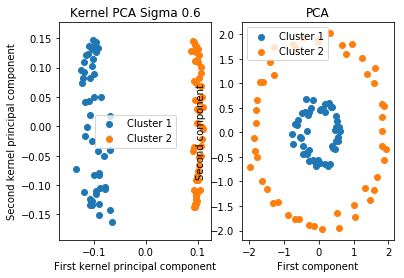

In [4]:
# ------------------------------ Kernel PCA ------------------------------ #
# a) Generate a simulated data set
np.random.seed(0)

x, y = make_circles(n_samples=100, factor=.3, noise=.05)

data = pd.DataFrame(x)
data.index = np.arange(100)
data['label'] = y

# plt.figure(1)
# dot1 = plt.scatter(data.iloc[np.where(data['label'] == 1)[0].tolist(), 0], data.iloc[np.where(data['label'] == 1)[0].tolist(), 1])
# dot2 = plt.scatter(data.iloc[np.where(data['label'] == 0)[0].tolist(), 0], data.iloc[np.where(data['label'] == 0)[0].tolist(), 1])
#
# plt.xlabel('x')
# plt.ylabel('y')
# plt.legend([dot1, dot2], ["Cluster 1", "Cluster 2"])
# plt.title('Scatter Plot of the original data')

# b) Perform PCA
# Gaussian (RBF) Kernel
def gaussian_kernel(x, y, sigma=1):
    """
    Compute the Gaussian(RBF) kernel between X and Y for each pair of rows x in X and y in Y.

    :param x: matrix1
    :param y: matrix2
    :param sigma: hyper-parameter in Gaussian kernel
    :return: kernel matrix
    """

    # Considering the rows of X, Y as vectors, compute the distance matrix between each pair of vectors.(sklearn)
    xx = np.einsum('ij,ij->i', x, x)[:, np.newaxis]
    yy = np.einsum('ij,ij->i', y, y)[np.newaxis, :]
    k = x.dot(y.T)
    k *= -2
    k += xx
    k += yy
    k = np.maximum(k, 0.)

    # Gaussian Kernel
    k /= -(sigma**2.)
    k = np.exp(k)

    return k

# Center the kernel matrix
kernel_matrix_centered = ((np.eye(100, 100) - np.repeat(1, 10000).reshape((100, 100))/100
                           ).dot(gaussian_kernel(np.array(data.iloc[:, 0:2]), np.array(data.iloc[:, 0:2]), 0.6))
                          ).dot(np.eye(100, 100) - np.repeat(1, 10000).reshape((100, 100))/100)

# Power Iteration Algorithm
def power_iteration(A):
    n, d = A.shape

    v = np.ones(d) / np.sqrt(d)
    ev = v.dot(A.dot(v))

    while True:
        Av = A.dot(v)
        v_new = Av / np.linalg.norm(Av)

        ev_new = v_new.dot(A.dot(v_new))
        if np.abs(ev - ev_new) < 0.01:
            break

        v = v_new
        ev = ev_new

    return ev_new, v_new

eigen_value1, eigen_vector1 = power_iteration(kernel_matrix_centered)
alpha1 = eigen_vector1 / sqrt(eigen_value1)

kpc1 = alpha1.dot(kernel_matrix_centered)

# c) Compute k principle components
def k_principle_cal(X, k=1):
    """
    Calculate the first k principal components based on power iteration algorithm

    :param X: sample matrix
    :param k: the number of principal components
    :return: the first k principal components and their eigenvalues respectively
    """

    initial_component = pd.DataFrame(np.zeros(X.shape[1]))

    eigen_value = []
    eigen_vector = []

    for i in np.arange(k):
        Xnew = X - (X.dot(initial_component)).dot(initial_component.T)
        eva, eve = power_iteration(Xnew.T.dot(Xnew))

        eigen_value.append(eva)
        eigen_vector.append(eve.tolist())

        initial_component = pd.DataFrame(eve).copy()

    return eigen_value, pd.DataFrame(eigen_vector).T

keigen_value, keigen_vector = k_principle_cal(kernel_matrix_centered, 2)
alpha = np.array(keigen_vector / sqrt(keigen_value))

kpc = kernel_matrix_centered.dot(alpha)

# d) Visualize the dataset projected on first two kpcs
# Plot of first two kernel principal component score vectors
kfirst2component = pd.DataFrame(kpc)
kfirst2component['label'] = data['label']

plt.subplot(121)
dot1 = plt.scatter(kfirst2component.loc[np.where(kfirst2component['label'] == 1)[0].tolist(), 0], kfirst2component.loc[np.where(kfirst2component['label'] == 1)[0].tolist(), 1])
dot2 = plt.scatter(kfirst2component.loc[np.where(kfirst2component['label'] == 0)[0].tolist(), 0], kfirst2component.loc[np.where(kfirst2component['label'] == 0)[0].tolist(), 1])

plt.xlabel('First kernel principal component')
plt.ylabel('Second kernel principal component')
plt.legend([dot1, dot2], ["Cluster 1", "Cluster 2"])
plt.title('Kernel PCA Sigma 0.6')

eigen_value, eigen_vector = k_principle_cal(scale(data.iloc[:, 0:2], with_mean=True, with_std=True), 2)
pcafirst2component = pd.DataFrame(scale(data.iloc[:, 0:2], with_mean=True, with_std=True).dot(eigen_vector), columns=['c1', 'c2'])
pcafirst2component['label'] = data['label']

plt.subplot(122)
pcadot1 = plt.scatter(pcafirst2component.loc[np.where(pcafirst2component['label'] == 1)[0].tolist(), 'c1'], pcafirst2component.loc[np.where(pcafirst2component['label'] == 1)[0].tolist(), 'c2'])
pcadot2 = plt.scatter(pcafirst2component.loc[np.where(pcafirst2component['label'] == 0)[0].tolist(), 'c1'], pcafirst2component.loc[np.where(pcafirst2component['label'] == 0)[0].tolist(), 'c2'])

plt.xlabel('First component')
plt.ylabel('Second component')
plt.legend([pcadot1, pcadot2,], ["Cluster 1", "Cluster 2"])
plt.title('PCA')
plt.show()